# TP Clustering

In [2]:
from sklearn import cluster
from scipy.io import arff
from sklearn import metrics
from sklearn.datasets import make_blobs
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import time
import random
import sys


f_silhouette = lambda X,labels : [None, 0] if X == None and labels == None else [metrics.silhouette_score(X, labels, metric="euclidean"),0] 
f_calHar = lambda X,labels : [None, 0] if X == None and labels == None else [metrics.calinski_harabasz_score(X, labels),0]
f_davBou = lambda X,labels : [None, 1] if X == None and labels == None else [metrics.davies_bouldin_score(X, labels), 1]
f_calhs =  lambda X,labels : [None, 0] if X == None and labels == None else [metrics.calinski_harabasz_score(X, labels),0]

c_KMeans = lambda n_clusters,_ : cluster.KMeans(n_clusters, init='k-means++',random_state=3)
c_Agglo = lambda n_clusters,manieres : cluster.AgglomerativeClustering(n_clusters,linkage=manieres, affinity='euclidean')
c_DBSCAN = lambda eps,min_samples : cluster.DBSCAN(eps = eps, min_samples = min_samples)
c_HDBSCAN = lambda min_size , _ : hdbscan.HDBSCAN(min_size)

## 1 Jeux de données
Les jeux de données sont disponibles sur le site : https://github.com/deric/clustering-benchmark.
Seuls les jeux de données "artificiels" seront considérés dans ces TP.

Identifiez pour cela dans la documentation de scikitlearn 1 les métriques qui vous semblent
pertinentes.https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

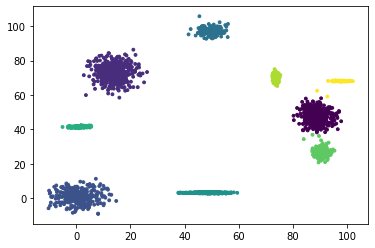

Best cluster number :  9  Best score :  0.8377446510558256
Runtime :  2068.2 ms


In [11]:
fileTestName = "2d-10c.arff"

#colors = ['r','b','y','g', 'lime', 'bisque', 'lightcoral', 'mediumturquoise', 'sandybrown', 'black']
#colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(100)]

nbClusters = 9

def load_file(filepath):
    return arff.loadarff(open(filepath, 'r',encoding="utf-8"))

data = load_file("./artificial/"+fileTestName)[0]

new_data = []
x_list = []
y_list = []
z_list = []
for (x,y,_) in data : 
    new_data.append([x,y])
    x_list.append(x)
    y_list.append(y)
    
kmeans = cluster.KMeans(n_clusters=nbClusters, init='k-means++').fit(new_data)
labels = kmeans.labels_

#for (x,y,_) in zip(x_list, y_list, kmeans.labels_):
    #plt.plot(x, y,'o',color=colors[c])    
#plt.plot(x_list, y_list,'o',color=colors[indexColor])

plt.scatter(x_list, y_list, c=labels,s=8)
plt.show()

i_max = -1
score_max = 0
starttime = time.time()

for i in range(2,10) :
    data_temp = new_data;
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++').fit(data_temp)
    labels = kmeans.labels_
    score = metrics.silhouette_score(data_temp, labels, metric='euclidean')
    if score > score_max :
        i_max = i
        score_max = score

endtime = time.time()
print("Best cluster number : ",i_max," Best score : ",score_max)
print("Runtime : ", round((endtime - starttime)*1000,2),"ms")

In [1]:
def clustering(fileName,c_cluster,metric,arg0_cluster,arg1_cluster,best_cluster):
    #preload the data
    path = "./artificial/"
    data = arff.loadarff(open(path+fileName, 'r',encoding="utf-8"))[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    [_, cmp] = metric(None, None)
    score_max = cmp*sys.maxsize
    best_kmeans = None
    starttime = time.time()
    data_temp = new_data
    
    #cluster begin
    if best_cluster == 0 :
        #case number of cluster given
         
        res_cluster = c_cluster(arg0_cluster,arg1_cluster).fit(data_temp)
        labels = res_cluster.labels_
        [score, _] = metric(data_temp, labels)
        endtime = time.time()        
        
        visualisation(x_list,y_list,labels)
        evaluation(data_temp,starttime,endtime,metric,labels,score)
    else :
        #need to find the best cluster number
        if c_cluster != c_DBSCAN :
            min_range=2
            max_range=50
            if c_cluster == c_HDBSCAN :
                max_range = arg0_cluster
            for i in range(min_range,max_range) :
                data_temp = new_data;
                try:
                    res_cluster = c_cluster(i,arg1_cluster).fit(data_temp)
                    labels = res_cluster.labels_

                    [score, cmp] = metric(data_temp, labels)

                    if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
                        score_max = score
                        best_kmeans=labels
                except:
                    pass
            endtime = time.time()

            visualisation(x_list,y_list,best_kmeans)
            evaluation(data_temp,starttime,endtime,metric,best_kmeans,score_max)
        else :
            min_range=1
            step=1
            for i in [ x /1.0 for x in range(min_range,arg0_cluster,step)] : 
                for j in range(min_range,arg1_cluster,step) :
                    data_temp = new_data;
                    try:
                        res_cluster = c_cluster(i,j).fit(data_temp)
                        labels = res_cluster.labels_
                        [score, cmp] = metric(data_temp, labels)

                        if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
                            score_max = score
                            best_kmeans=labels
                    except:
                        pass
            endtime = time.time()
            visualisation(x_list,y_list,best_kmeans)
            evaluation(data_temp,starttime,endtime,metric,best_kmeans,score_max)
        
     
        
def evaluation(data_temp,starttime,endtime,metric,labels,score_max):
    try :
        print("Best cluster number : ",labels.max()+1, " Best score : ",score_max)
    except :
        pass
    print("Runtime : ", round((endtime - starttime)*1000,2),"ms")
    
def visualisation(x_list,y_list,labels):
    plt.scatter(x_list, y_list, c=labels,s=10,cmap="rainbow")
    plt.show()

# 2 Clustering k-Means

### 2.1 Intérêts de la méthode

Appliquez la méthodek-Means en lui donnant directement le nombre de clusters attendus (uti-lisez l’initialisationk-means++)

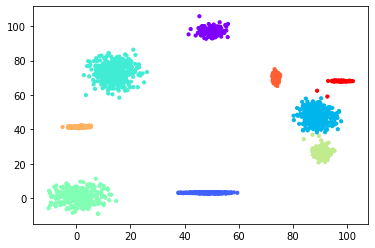

Best cluster number :  9  Best score :  0.8377446510558256
Runtime :  248.08 ms


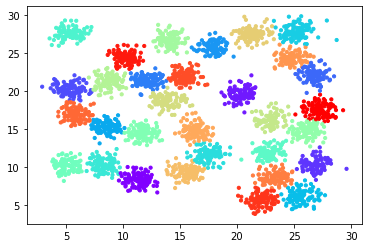

Best cluster number :  31  Best score :  0.5755674273166536
Runtime :  422.73 ms


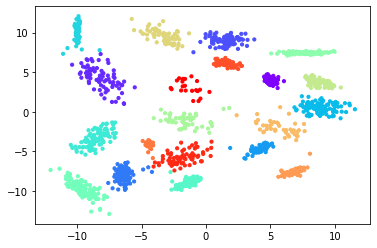

Best cluster number :  20  Best score :  0.6616821653207235
Runtime :  158.87 ms


In [102]:
clustering("2d-10c.arff",c_KMeans,f_silhouette,9,_,0)
clustering("D31.arff",c_KMeans,f_silhouette,31,_,0)
clustering("2d-20c-no0.arff",c_KMeans,f_silhouette,20,_,0)

Appliquez itérativement la méthode précédente pour déterminer le bon nombre de clusters àl’aide de métriques d’évaluation sélectionnées

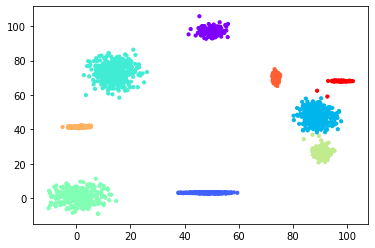

Best cluster number :  9  Best score :  0.8377446510558256
Runtime :  19034.82 ms


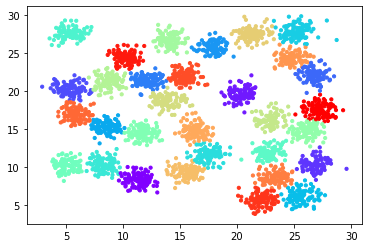

Best cluster number :  31  Best score :  0.5755674273166536
Runtime :  21213.44 ms


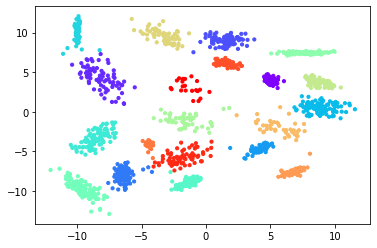

Best cluster number :  20  Best score :  0.6616821653207235
Runtime :  10082.05 ms


In [78]:
#silhouette_score
clustering("2d-10c.arff",c_KMeans,f_silhouette,_,_,1)
clustering("D31.arff",c_KMeans,f_silhouette,_,_,1)
clustering("2d-20c-no0.arff",c_KMeans,f_silhouette,_,_,1)

Best cluster number :  22  Best score :  52541.76903460113
Runtime :  12224.08 ms


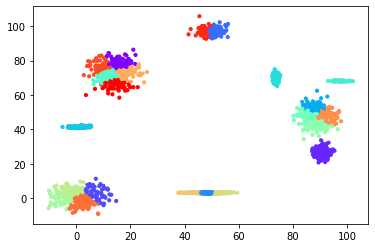

Best cluster number :  31  Best score :  9167.98090794413
Runtime :  13675.98 ms


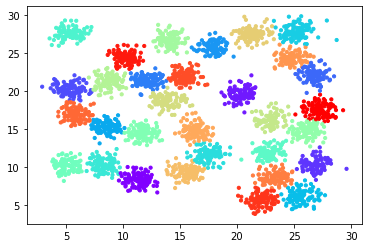

Best cluster number :  37  Best score :  7020.290573219402
Runtime :  7477.17 ms


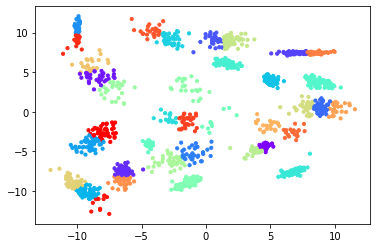

In [51]:
#Calinski-Harabasz Index
clustering("2d-10c.arff",c_KMeans,f_calHar,_,_,1)
clustering("D31.arff",c_KMeans,f_calHar,_,_,1)
clustering("2d-20c-no0.arff",c_KMeans,f_calHar,_,_,1)

Best cluster number :  9  Best score :  0.22821719896766357
Runtime :  12282.56 ms


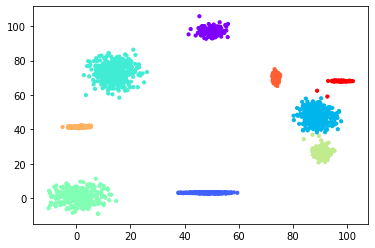

Best cluster number :  31  Best score :  0.5471933004835284
Runtime :  13912.46 ms


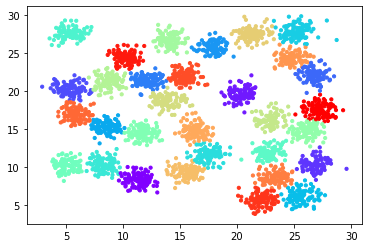

Best cluster number :  20  Best score :  0.4734515211021004
Runtime :  7651.74 ms


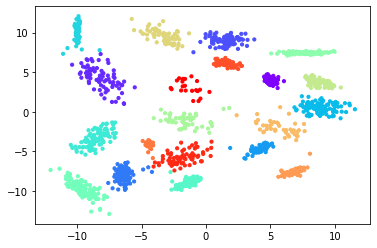

In [52]:
#Davies-Bouldin Index
clustering("2d-10c.arff",c_KMeans,f_davBou,_,_,1)
clustering("D31.arff",c_KMeans,f_davBou,_,_,1)
clustering("2d-20c-no0.arff",c_KMeans,f_davBou,_,_,1)

### 2.2 Limites de la méthode

In [1]:
clustering("3-spiral.arff",c_KMeans,f_silhouette,_,_,1)

NameError: name 'clustering' is not defined

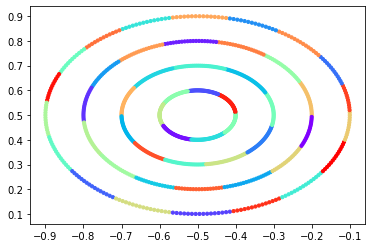

Best cluster number :  49  Best score :  0.4798928353619385
Runtime :  8591.92 ms


In [80]:
clustering("dartboard1.arff",c_KMeans,f_silhouette,_,_,1)

La méthode ne permet pas d'identifier des clusters non convexes.  
Cela est inhérent à la manière dont elle fonctionne.  
Une autre métrique d'évaluation ne permettrait pas d'identifier correctement les clusters dans les 2 cas précédents.

### 2.3 Evalution

In [182]:
def kMeansTime(fileTestName,begin,end):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    run_time=[]
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    i_max = 0
    score_max = 0
    starttime = time.time()
    
    for i in range(begin,end) :
        data_temp = new_data;
        kmeans = cluster.KMeans(n_clusters=i, init='k-means++',random_state=3).fit(data_temp)
        labels = kmeans.labels_
        score = metrics.silhouette_score(data_temp, labels, metric='euclidean')
        if score > score_max :
            i_max = i
            score_max = score
        endtime = time.time()
        run_time.append(round((endtime - starttime)*1000,2))
    
    plt.plot(range(begin,end), run_time, 'b^-',label='trendence')
    plt.legend()
    #plt.set_title('relation between runtime and cluster number')
    #plt.set_xlabel('number of cluster')
    #plt.set_ylabel('run time \(ms\)')
    plt.show()
    print("Best cluster number : ",i_max, " Best score : ",score_max)
    

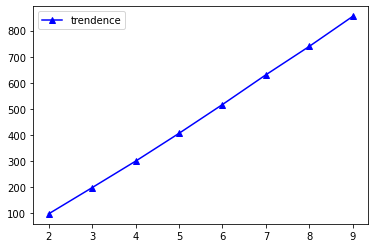

Best cluster number :  9  Best score :  0.8377446510558256


In [183]:
kMeansTime("2d-10c.arff",2,10)

# 3 Clustering agglomératif

### 3.1 Intérêts de la méthode

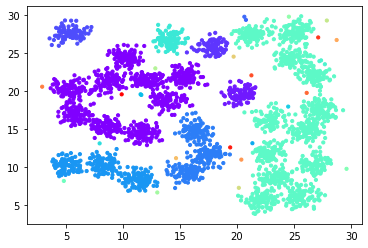

Best cluster number :  31  Best score :  -0.3896440188293575
Runtime :  243.41 ms


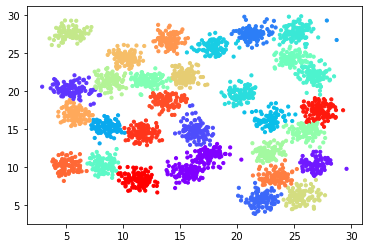

Best cluster number :  31  Best score :  0.5622700040906442
Runtime :  334.59 ms


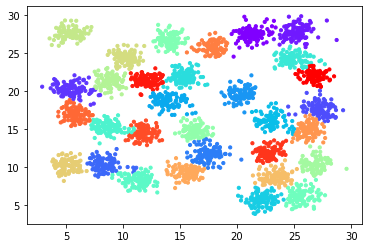

Best cluster number :  31  Best score :  0.5636664592980722
Runtime :  386.6 ms


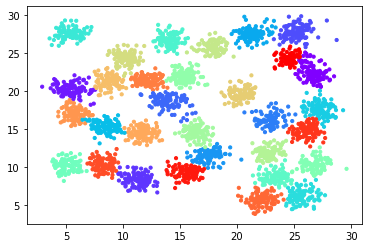

Best cluster number :  31  Best score :  0.5640591525907602
Runtime :  402.42 ms


In [103]:
clustering("D31.arff",c_Agglo,f_silhouette,31,'single',0)
clustering("D31.arff",c_Agglo,f_silhouette,31,'average',0)
clustering("D31.arff",c_Agglo,f_silhouette,31,'complete',0)
clustering("D31.arff",c_Agglo,f_silhouette,31,'ward',0)

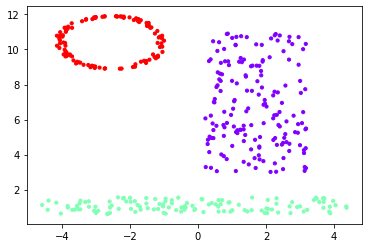

Best cluster number :  3  Best score :  0.4956142510948985
Runtime :  10.4 ms


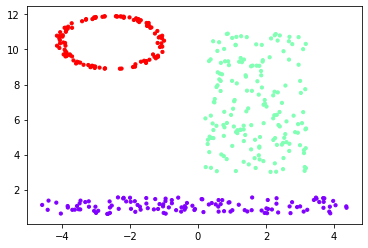

Best cluster number :  3  Best score :  0.4956142510948985
Runtime :  8.92 ms


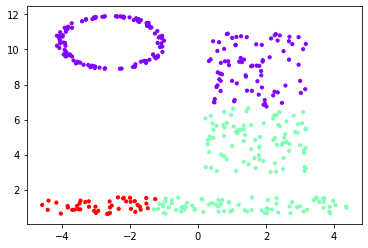

Best cluster number :  3  Best score :  0.45738534560833777
Runtime :  13.24 ms


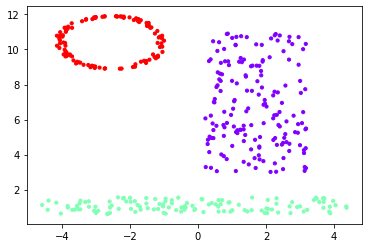

Best cluster number :  3  Best score :  0.4956142510948985
Runtime :  10.21 ms


In [104]:
clustering("3MC.arff",c_Agglo,f_silhouette,3,'single',0)
clustering("3MC.arff",c_Agglo,f_silhouette,3,'average',0)
clustering("3MC.arff",c_Agglo,f_silhouette,3,'complete',0)
clustering("3MC.arff",c_Agglo,f_silhouette,3,'ward',0)

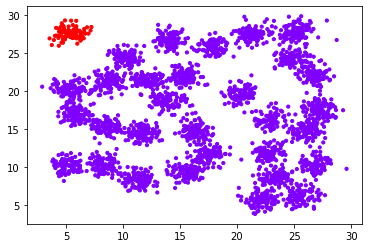

Best cluster number :  2  Best score :  0.23044322898606115
Runtime :  11743.1 ms


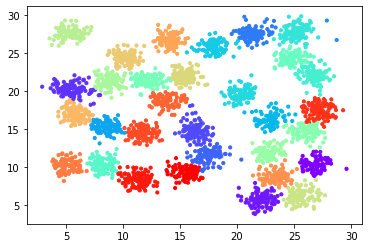

Best cluster number :  32  Best score :  0.5666400765005847
Runtime :  17148.04 ms


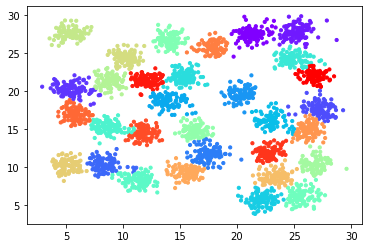

Best cluster number :  31  Best score :  0.5636664592980722
Runtime :  17931.95 ms


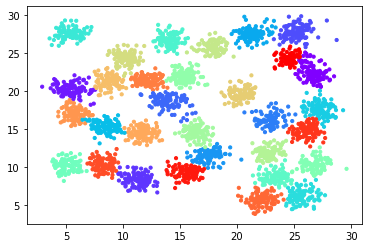

Best cluster number :  31  Best score :  0.5640591525907602
Runtime :  18698.55 ms


In [105]:
clustering("D31.arff",c_Agglo,f_silhouette,_,'single',1)
clustering("D31.arff",c_Agglo,f_silhouette,_,'average',1)
clustering("D31.arff",c_Agglo,f_silhouette,_,'complete',1)
clustering("D31.arff",c_Agglo,f_silhouette,_,'ward',1)

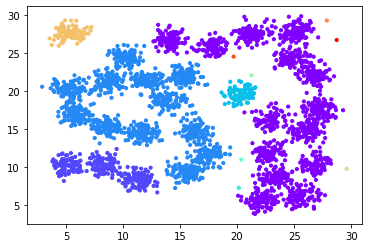

Best cluster number :  12  Best score :  288.26138425390917
Runtime :  3736.68 ms


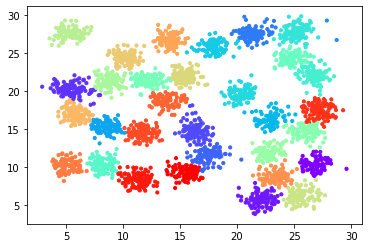

Best cluster number :  32  Best score :  8683.26193359154
Runtime :  9198.96 ms


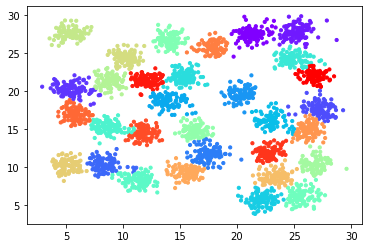

Best cluster number :  31  Best score :  8763.753449812082
Runtime :  9635.82 ms


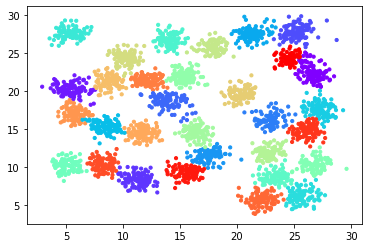

Best cluster number :  31  Best score :  8778.524791454909
Runtime :  11007.39 ms


In [106]:
clustering("D31.arff",c_Agglo,f_calHar,_,'single',1)
clustering("D31.arff",c_Agglo,f_calHar,_,'average',1)
clustering("D31.arff",c_Agglo,f_calHar,_,'complete',1)
clustering("D31.arff",c_Agglo,f_calHar,_,'ward',1)

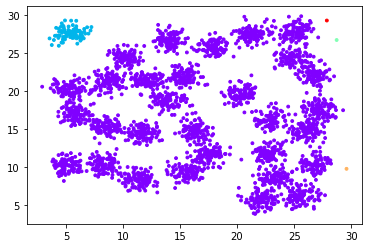

Best cluster number :  5  Best score :  0.6147049191068784
time execution :  1850.89 ms


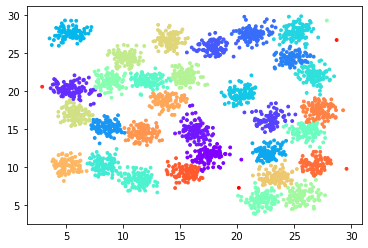

Best cluster number :  36  Best score :  0.5241419099213152
time execution :  5802.26 ms


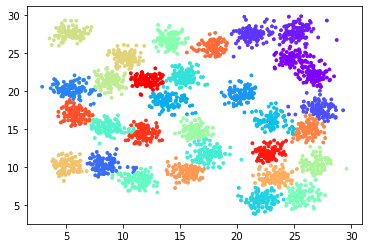

Best cluster number :  30  Best score :  0.5588565838365422
time execution :  6058.46 ms


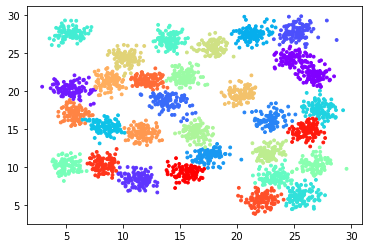

Best cluster number :  30  Best score :  0.5539703648101987
time execution :  6284.07 ms


In [198]:
clustering("D31.arff",c_Agglo,f_davBou,_,'single',1)
clustering("D31.arff",c_Agglo,f_davBou,_,'average',1)
clustering("D31.arff",c_Agglo,f_davBou,_,'complete',1)
clustering("D31.arff",c_Agglo,f_davBou,_,'ward',1)

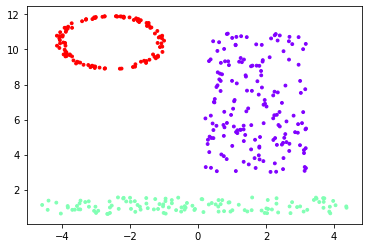

Best cluster number :  3  Best score :  0.4956142510948985
time execution :  196.66 ms


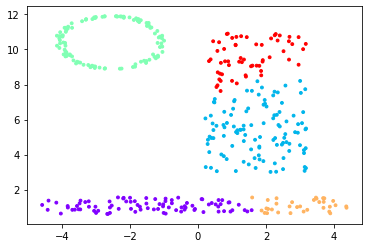

Best cluster number :  5  Best score :  0.5019966425875431
time execution :  206.7 ms


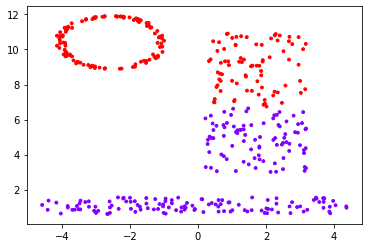

Best cluster number :  2  Best score :  0.5319623563925211
time execution :  233.38 ms


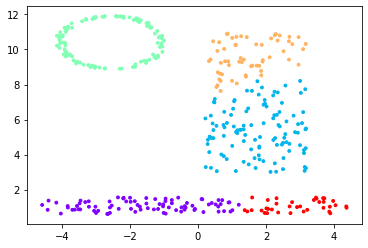

Best cluster number :  5  Best score :  0.5063895038472094
time execution :  249.48 ms


In [199]:
clustering("3MC.arff",c_Agglo,f_silhouette,_,'single',1)
clustering("3MC.arff",c_Agglo,f_silhouette,_,'average',1)
clustering("3MC.arff",c_Agglo,f_silhouette,_,'complete',1)
clustering("3MC.arff",c_Agglo,f_silhouette,_,'ward',1)

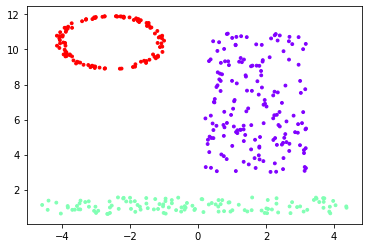

Best cluster number :  3  Best score :  628.0489014193492
time execution :  112.99 ms


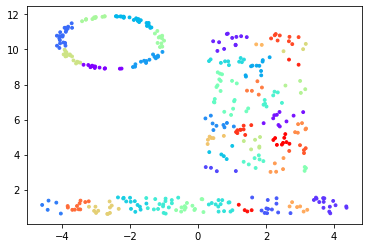

Best cluster number :  44  Best score :  1506.4397525965242
time execution :  161.43 ms


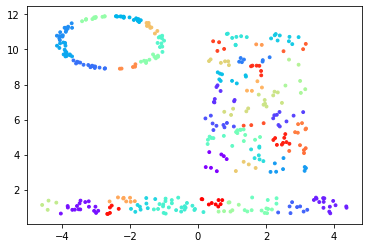

Best cluster number :  49  Best score :  1557.2805787828577
time execution :  157.66 ms


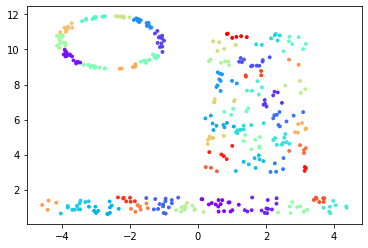

Best cluster number :  49  Best score :  1723.0165360627886
time execution :  170.52 ms


In [200]:
clustering("3MC.arff",c_Agglo,f_calHar,_,'single',1)
clustering("3MC.arff",c_Agglo,f_calHar,_,'average',1)
clustering("3MC.arff",c_Agglo,f_calHar,_,'complete',1)
clustering("3MC.arff",c_Agglo,f_calHar,_,'ward',1)

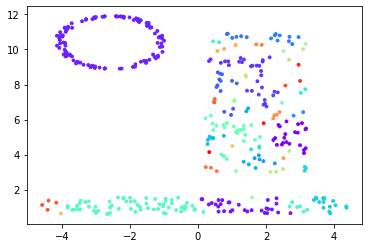

Best cluster number :  48  Best score :  0.5843535758982878
time execution :  270.67 ms


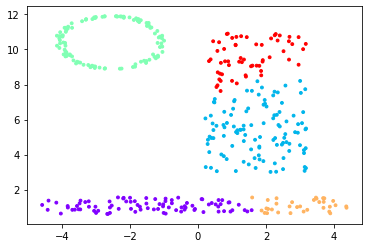

Best cluster number :  5  Best score :  0.5830870921521715
time execution :  307.0 ms


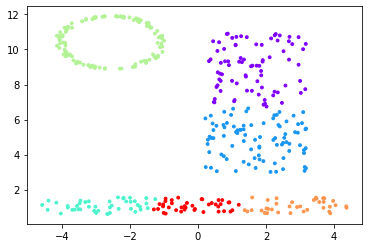

Best cluster number :  6  Best score :  0.6027438479849588
time execution :  307.48 ms


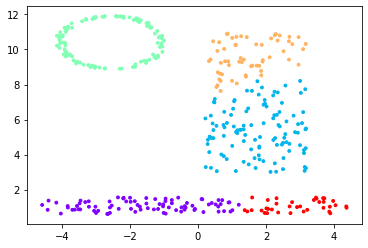

Best cluster number :  5  Best score :  0.5832075693321912
time execution :  315.2 ms


In [201]:
clustering("3MC.arff",c_Agglo,f_davBou,_,'single',1)
clustering("3MC.arff",c_Agglo,f_davBou,_,'average',1)
clustering("3MC.arff",c_Agglo,f_davBou,_,'complete',1)
clustering("3MC.arff",c_Agglo,f_davBou,_,'ward',1)

### 3.2 Limites de la méthode

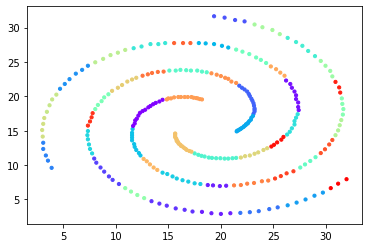

Best cluster number :  48  Best score :  0.4467478405947203
Runtime :  308.39 ms


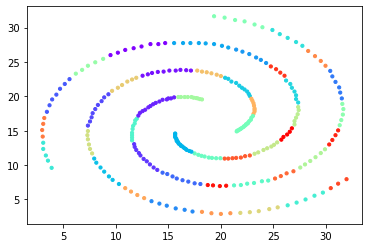

Best cluster number :  45  Best score :  0.45282010195284783
Runtime :  346.42 ms


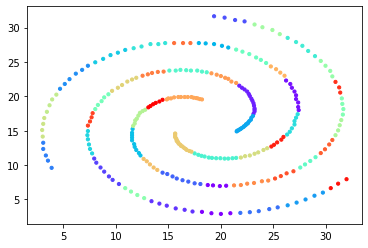

Best cluster number :  49  Best score :  423.8460657265097
Runtime :  196.52 ms


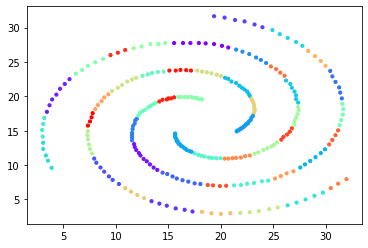

Best cluster number :  49  Best score :  455.7222996473953
Runtime :  189.61 ms


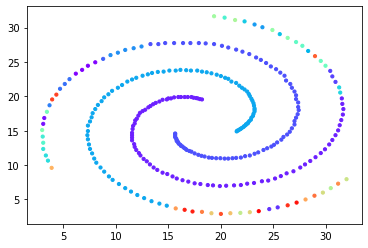

Best cluster number :  49  Best score :  0.8293094100461474
Runtime :  377.3 ms


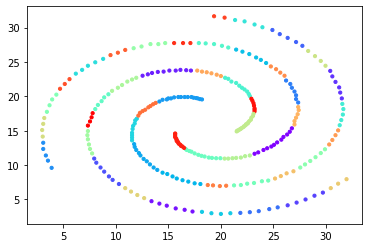

Best cluster number :  49  Best score :  0.5225178210744961
Runtime :  414.85 ms


In [107]:
clustering("3-spiral.arff",c_Agglo,f_silhouette,_,'complete',1)
clustering("3-spiral.arff",c_Agglo,f_silhouette,_,'ward',1)
clustering("3-spiral.arff",c_Agglo,f_calHar,_,'complete',1)
clustering("3-spiral.arff",c_Agglo,f_calHar,_,'ward',1)
clustering("3-spiral.arff",c_Agglo,f_davBou,_,'single',1)
clustering("3-spiral.arff",c_Agglo,f_davBou,_,'average',1)

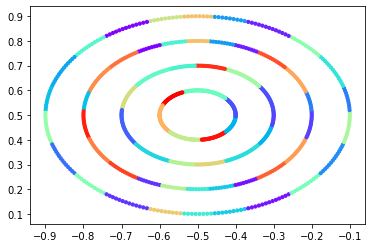

Best cluster number :  49  Best score :  0.3695384804205307
Runtime :  1879.54 ms


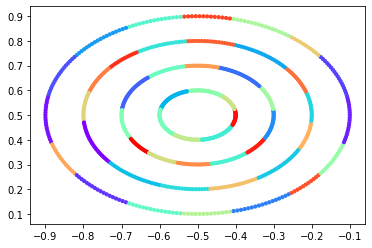

Best cluster number :  49  Best score :  0.45672259806953813
Runtime :  2093.23 ms


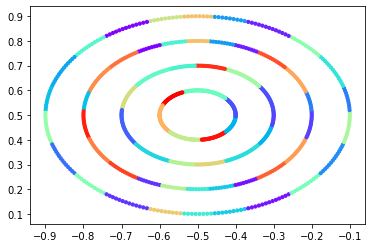

Best cluster number :  49  Best score :  815.7900935463683
Runtime :  963.29 ms


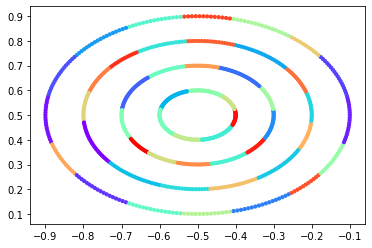

Best cluster number :  49  Best score :  1038.560950894871
Runtime :  1111.02 ms


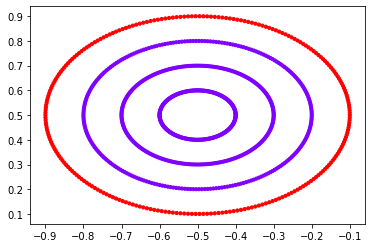

Best cluster number :  2  Best score :  0.0
Runtime :  729.85 ms


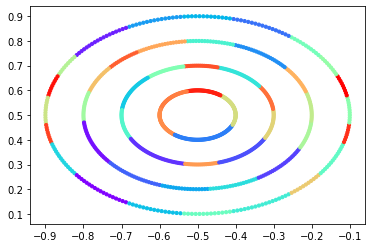

Best cluster number :  49  Best score :  0.6337524725695525
Runtime :  1223.1 ms


In [108]:
clustering("dartboard1.arff",c_Agglo,f_silhouette,_,'complete',1)
clustering("dartboard1.arff",c_Agglo,f_silhouette,_,'ward',1)
clustering("dartboard1.arff",c_Agglo,f_calHar,_,'complete',1)
clustering("dartboard1.arff",c_Agglo,f_calHar,_,'ward',1)
clustering("dartboard1.arff",c_Agglo,f_davBou,_,'single',1)
clustering("dartboard1.arff",c_Agglo,f_davBou,_,'average',1)

La méthode ne permet pas d'identifier des clusters non convexes.  
En effet, elle consiste à séparer ou agglomérer des points et groupes de points en se basant sur la distance qui les sépare (notion de proximité).  
Une autre métrique d'évaluation ne permettrait pas d'identifier correctement les clusters dans les 2 cas précédents.

## 4 Clustering DBSCAN

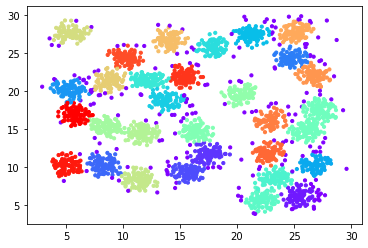

Best cluster number :  30  Best score :  0.5034771184442532
Runtime :  29346.39 ms


In [38]:
clustering("D31.arff",c_DBSCAN,f_silhouette,10,100,1)

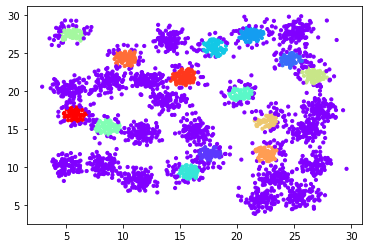

Best cluster number :  14  Best score :  -0.25275591392273505
Runtime :  86.98 ms


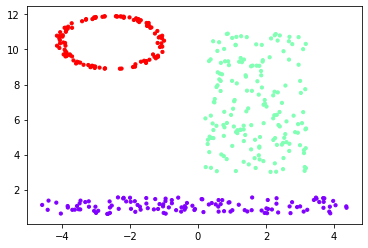

Best cluster number :  3  Best score :  628.0489014193492
Runtime :  1.85 ms


In [37]:
#clusterDBSCAN("3-spiral.arff",1,3)

clustering("D31.arff",c_DBSCAN,f_silhouette,1,63,0)
clustering("3MC.arff",c_DBSCAN,f_calhs,1,3,0)

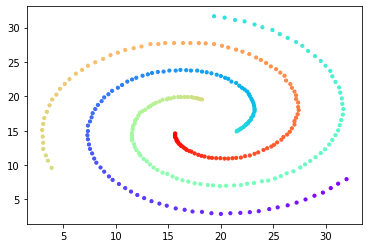

Best cluster number :  310  Best score :  26959.43295162275
Runtime :  141.9 ms


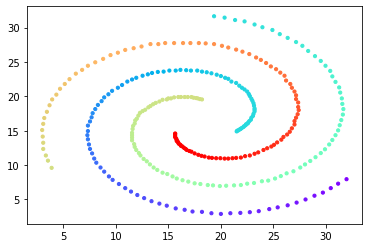

Best cluster number :  235  Best score :  0.122059579775187
Runtime :  181.13 ms


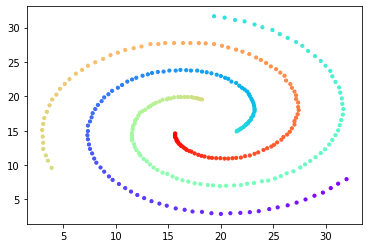

Best cluster number :  310  Best score :  0.012478740214114123
Runtime :  411.8 ms


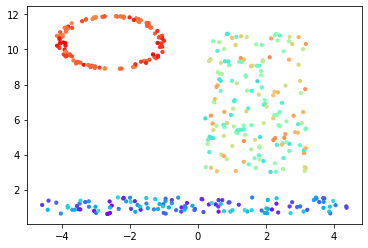

Best cluster number :  297  Best score :  6367.541031054565
Runtime :  150.48 ms


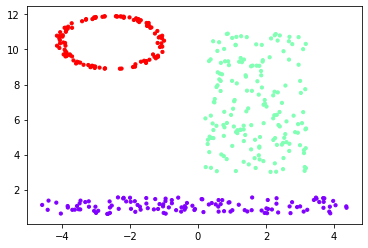

Best cluster number :  3  Best score :  0.4956142510948985
Runtime :  261.1 ms


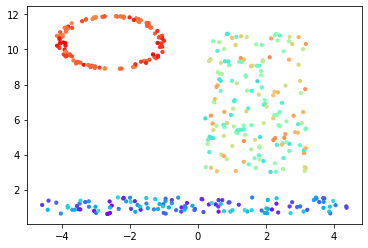

Best cluster number :  297  Best score :  0.15188624457349276
Runtime :  336.31 ms


In [30]:
clustering("3-spiral.arff",c_DBSCAN,f_calhs,10,10,1)
clustering("3-spiral.arff",c_DBSCAN,f_silhouette,10,10,1)
clustering("3-spiral.arff",c_DBSCAN,f_davBou,10,10,1)
clustering("3MC.arff",c_DBSCAN,f_calhs,10,10,1)
clustering("3MC.arff",c_DBSCAN,f_silhouette,10,10,1)
clustering("3MC.arff",c_DBSCAN,f_davBou,10,10,1)

### 4.2 Limites de la méthode

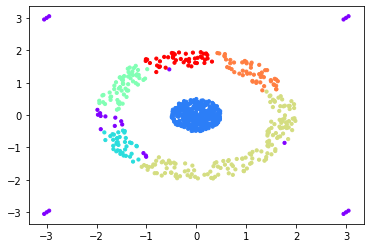

Best cluster number :  6  Best score :  193.054516006462
Runtime :  326.77 ms


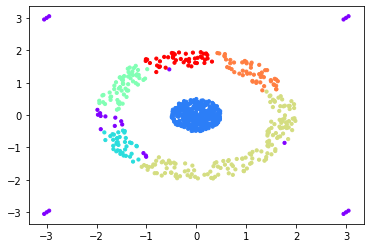

Best cluster number :  6  Best score :  0.49245526653761823
Runtime :  772.03 ms


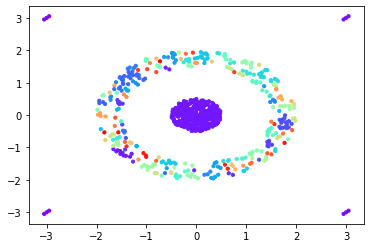

Best cluster number :  136  Best score :  0.4366895121797273
Runtime :  415.51 ms


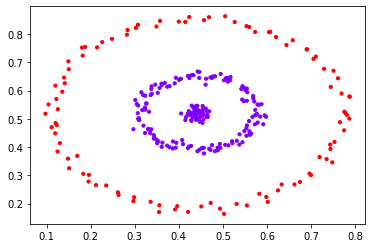

Best cluster number :  2  Best score :  0.017077598268838867
Runtime :  117.96 ms


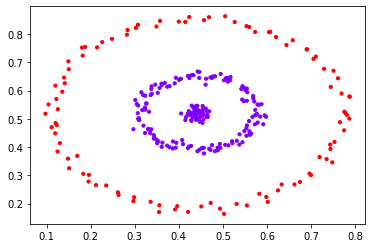

Best cluster number :  2  Best score :  0.3290893099753203
Runtime :  130.17 ms


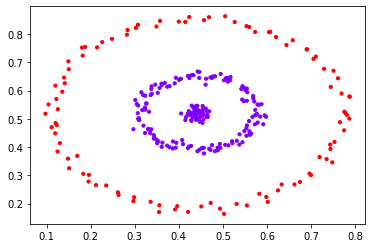

Best cluster number :  2  Best score :  125.83378561338588
Runtime :  119.17 ms


In [29]:
clustering("target.arff",c_DBSCAN,f_calhs,10,10,1)
clustering("target.arff",c_DBSCAN,f_silhouette,10,10,1)
clustering("target.arff",c_DBSCAN,f_davBou,10,10,1)
clustering("zelnik1.arff",c_DBSCAN,f_calhs,10,10,1)
clustering("zelnik1.arff",c_DBSCAN,f_silhouette,10,10,1)
clustering("zelnik1.arff",c_DBSCAN,f_davBou,10,10,1)

## 5 Clustering HDBSCAN

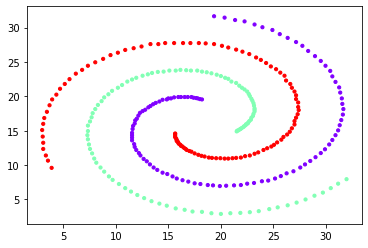

Best cluster number :  3  Best score :  5.797852185441633
Runtime :  12.82 ms


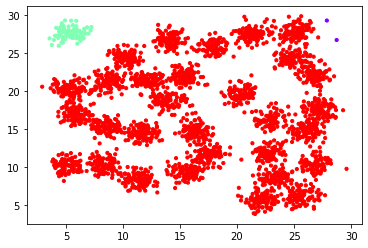

Best cluster number :  2  Best score :  137.35198600499015
Runtime :  63.99 ms


In [166]:
#clusterHDBSCAN("3-spiral.arff",10)
clustering("3-spiral.arff",c_HDBSCAN,f_calhs,2,_,0)
clustering("D31.arff",c_HDBSCAN,f_calhs,30,_,0)

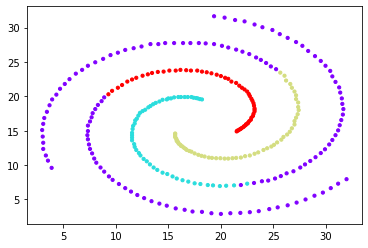

Best cluster number :  3  Best score :  9.390952241785563
Runtime :  365.24 ms


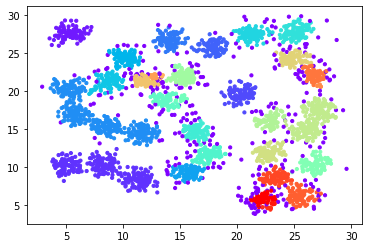

Best cluster number :  32  Best score :  700.8591410158665
Runtime :  3400.72 ms


In [167]:
clustering("3-spiral.arff",c_HDBSCAN,f_calhs,50,_,1)
clustering("D31.arff",c_HDBSCAN,f_calhs,50,_,1)

## 6 Synthèse

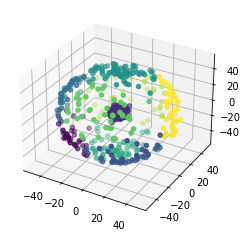

In [43]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = plt.axes(projection='3d')

with open("./dataset/a.data", "r") as dataFile: 
    data = [line.split() for line in dataFile]
i = 0
x = []
y = []
z = []
new_data =[]
for line in data:
    new_data.append([float(line[0]),float(line[1]),float(line[2])])
    x.append(float(line[0]))
    y.append(float(line[1]))
    z.append(float(line[2]))

kmeans = cluster.KMeans(n_clusters=nbClusters, init='k-means++').fit(new_data)
labels = kmeans.labels_

#for (x,y,_) in zip(x_list, y_list, kmeans.labels_):
    #plt.plot(x, y,'o',color=colors[c])    
#plt.plot(x_list, y_list,'o',color=colors[indexColor])
#print(labels)
ax1.scatter3D(x,y,z, c=labels)  #绘制散点图
plt.show()

In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def clustering_D(fileName,c_cluster,metric,arg0_cluster,arg1_cluster,best_cluster,dimension):
    #preload the data
    path = "./dataset/"
    with open(path+fileName, "r") as dataFile: 
        data = [line.split() for line in dataFile]
    new_data = []
    x_list = []
    y_list = []
    z_list = []
    for line in data :
        if dimension == 2:
            new_data.append([float(line[0]),float(line[1])])
        else:
            new_data.append([float(line[0]),float(line[1]),float(line[2])])
            z_list.append(float(line[2]))
        x_list.append(float(line[0]))
        y_list.append(float(line[1]))
    [_, cmp] = metric(None, None)
    score_max = cmp*sys.maxsize
    best_kmeans = None
    starttime = time.time()
    data_temp = new_data
    
    #cluster begin
    if best_cluster == 0 :
        #case number of cluster given
         
        res_cluster = c_cluster(arg0_cluster,arg1_cluster).fit(data_temp)
        labels = res_cluster.labels_
        [score, _] = metric(data_temp, labels)
        endtime = time.time()        
        
        if dimension == 2:
                visualisation(x_list,y_list,best_kmeans)
        else:
                visualisation_3D(x_list,y_list,z_list,best_kmeans)
        evaluation(data_temp,starttime,endtime,metric,labels,score)
    else :
        #need to find the best cluster number
        if c_cluster != c_DBSCAN :
            min_range=2
            max_range=50
            if c_cluster == c_HDBSCAN :
                max_range = arg0_cluster
            for i in range(min_range,max_range) :
                data_temp = new_data;
                try:
                    res_cluster = c_cluster(i,arg1_cluster).fit(data_temp)
                    labels = res_cluster.labels_

                    [score, cmp] = metric(data_temp, labels)

                    if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
                        score_max = score
                        best_kmeans=labels
                except:
                    pass
            endtime = time.time()
            if dimension == 2:
                visualisation(x_list,y_list,best_kmeans)
            else:
                visualisation_3D(x_list,y_list,z_list,best_kmeans)
            evaluation(data_temp,starttime,endtime,metric,best_kmeans,score_max)
        else :
            min_range=1
            step=1
            for i in [ x /1.0 for x in range(min_range,arg0_cluster,step)] : 
                for j in range(min_range,arg1_cluster,step) :
                    data_temp = new_data;
                    try:
                        res_cluster = c_cluster(i,j).fit(data_temp)
                        labels = res_cluster.labels_
                        [score, cmp] = metric(data_temp, labels)

                        if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
                            score_max = score
                            best_kmeans=labels
                    except:
                        pass
            endtime = time.time()
            if dimension == 2:
                visualisation(x_list,y_list,best_kmeans)
            else:
                visualisation_3D(x_list,y_list,z_list,best_kmeans)
            evaluation(data_temp,starttime,endtime,metric,best_kmeans,score_max)
        
     
        
def evaluation(data_temp,starttime,endtime,metric,labels,score_max):
    try :
        print("Best cluster number : ",labels.max()+1, " Best score : ",score_max)
    except :
        pass
    print("Runtime : ", round((endtime - starttime)*1000,2),"ms")
    
def visualisation_3D(x_list,y_list,z_list,labels):
    fig = plt.figure()
    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(x_list, y_list,z_list, c=labels,s=10,cmap="rainbow")
    plt.show()

def visualisation(x_list,y_list,labels):
    plt.scatter(x_list, y_list, c=labels,s=10,cmap="rainbow")
    plt.show()

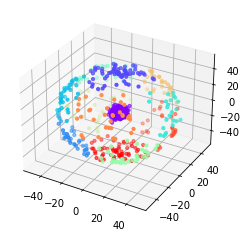

Best cluster number :  12  Best score :  0.6254538927641753
Runtime :  8394.75 ms


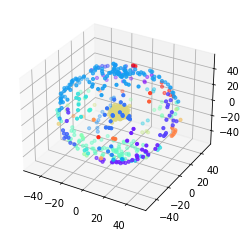

Best cluster number :  48  Best score :  0.4068197148493168
Runtime :  1194.1 ms


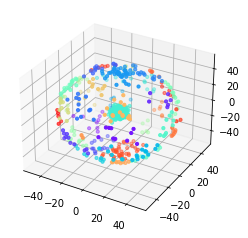

Best cluster number :  40  Best score :  0.6167270963497942
Runtime :  1485.62 ms


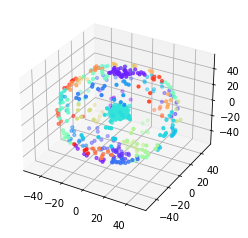

Best cluster number :  49  Best score :  0.6071547148117817
Runtime :  1546.47 ms


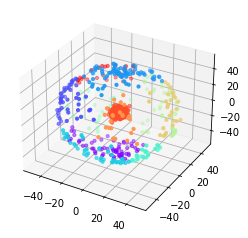

Best cluster number :  11  Best score :  0.6012875373212041
Runtime :  1648.19 ms


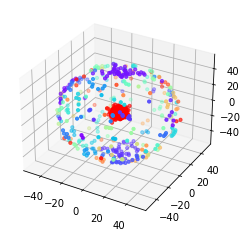

Best cluster number :  165  Best score :  0.5363162197266277
Runtime :  20947.17 ms


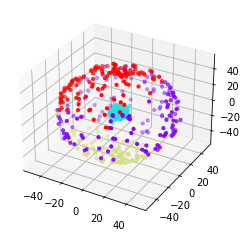

Best cluster number :  3  Best score :  0.4611686741443048
Runtime :  2094.84 ms


In [62]:
clustering_D("a.data",c_KMeans,f_silhouette,_,_,1,3)
clustering_D("a.data",c_Agglo,f_silhouette,_,'single',1,3)
clustering_D("a.data",c_Agglo,f_silhouette,_,'average',1,3)
clustering_D("a.data",c_Agglo,f_silhouette,_,'complete',1,3)
clustering_D("a.data",c_Agglo,f_silhouette,_,'ward',1,3)
clustering_D("a.data",c_DBSCAN,f_silhouette,10,100,1,3)
clustering_D("a.data",c_HDBSCAN,f_silhouette,50,_,1,3)

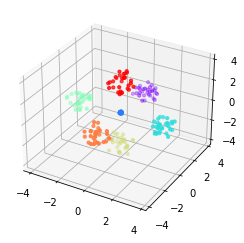

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  5180.39 ms


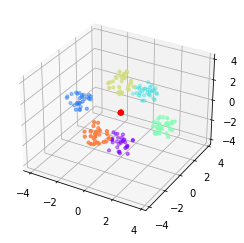

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  186.64 ms


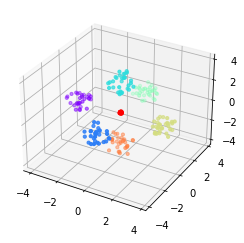

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  240.72 ms


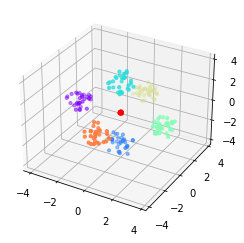

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  231.41 ms


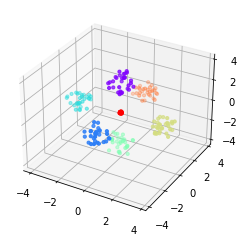

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  240.11 ms


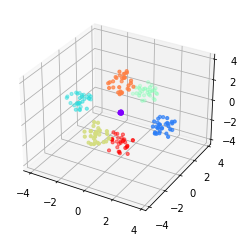

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  3085.35 ms


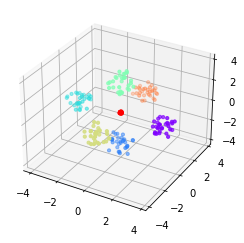

Best cluster number :  7  Best score :  0.7019231989948802
Runtime :  517.18 ms


In [5]:
clustering_D("h.data",c_KMeans,f_silhouette,_,_,1,3)
clustering_D("h.data",c_Agglo,f_silhouette,_,'single',1,3)
clustering_D("h.data",c_Agglo,f_silhouette,_,'average',1,3)
clustering_D("h.data",c_Agglo,f_silhouette,_,'complete',1,3)
clustering_D("h.data",c_Agglo,f_silhouette,_,'ward',1,3)
clustering_D("h.data",c_DBSCAN,f_silhouette,10,100,1,3)
clustering_D("h.data",c_HDBSCAN,f_silhouette,50,_,1,3)

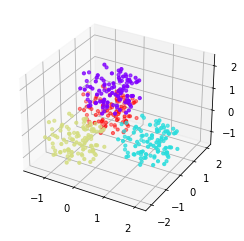

Best cluster number :  4  Best score :  0.5057889289788572
Runtime :  6269.65 ms


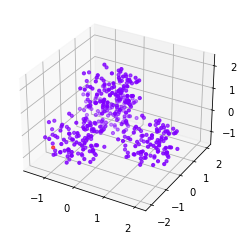

Best cluster number :  2  Best score :  0.13329304689331012
Runtime :  416.31 ms


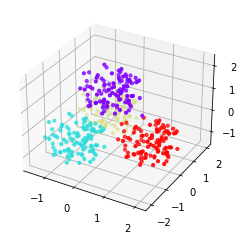

Best cluster number :  4  Best score :  0.5046643743963499
Runtime :  501.08 ms


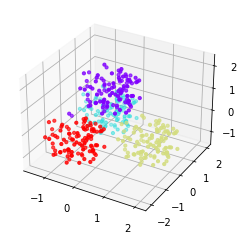

Best cluster number :  4  Best score :  0.5010021884877641
Runtime :  578.32 ms


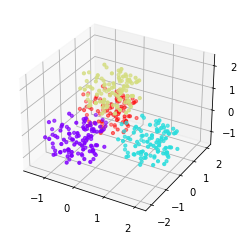

Best cluster number :  4  Best score :  0.4952113887827159
Runtime :  564.39 ms


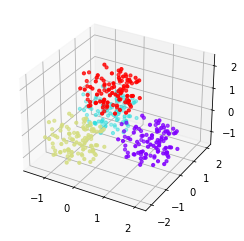

Best cluster number :  4  Best score :  0.5046603636871296
Runtime :  4626.09 ms


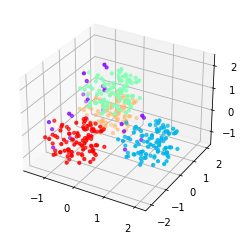

Best cluster number :  4  Best score :  0.4398045506347541
Runtime :  833.97 ms


In [65]:
clustering_D("t.data",c_KMeans,f_silhouette,_,_,1,3)
clustering_D("t.data",c_Agglo,f_silhouette,_,'single',1,3)
clustering_D("t.data",c_Agglo,f_silhouette,_,'average',1,3)
clustering_D("t.data",c_Agglo,f_silhouette,_,'complete',1,3)
clustering_D("t.data",c_Agglo,f_silhouette,_,'ward',1,3)
clustering_D("t.data",c_DBSCAN,f_silhouette,10,100,1,3)
clustering_D("t.data",c_HDBSCAN,f_silhouette,50,_,1,3)

In [ ]:
clustering_D("tr.data",c_KMeans,f_silhouette,_,_,1,2)
clustering_D("tr.data",c_Agglo,f_silhouette,_,'single',1,2)
clustering_D("tr.data",c_Agglo,f_silhouette,_,'average',1,2)
clustering_D("tr.data",c_Agglo,f_silhouette,_,'complete',1,2)
clustering_D("tr.data",c_Agglo,f_silhouette,_,'ward',1,2)
clustering_D("tr.data",c_DBSCAN,f_silhouette,10,100,1,2)
clustering_D("tr.data",c_HDBSCAN,f_silhouette,50,_,1,2)

In [ ]:
clustering_D("zgn.data",c_KMeans,f_silhouette,_,_,1,2)
clustering_D("zgn.data",c_Agglo,f_silhouette,_,'single',1,2)
clustering_D("zgn.data",c_Agglo,f_silhouette,_,'average',1,2)
clustering_D("zgn.data",c_Agglo,f_silhouette,_,'complete',1,2)
clustering_D("zgn.data",c_Agglo,f_silhouette,_,'ward',1,2)
clustering_D("zgn.data",c_DBSCAN,f_silhouette,10,100,1,2)
clustering_D("zgn.data",c_HDBSCAN,f_silhouette,50,_,1,2)

In [ ]:
clustering_D("zgo.data",c_KMeans,f_silhouette,_,_,1,2)
clustering_D("zgo.data",c_Agglo,f_silhouette,_,'single',1,2)
clustering_D("zgo.data",c_Agglo,f_silhouette,_,'average',1,2)
clustering_D("zgo.data",c_Agglo,f_silhouette,_,'complete',1,2)
clustering_D("zgo.data",c_Agglo,f_silhouette,_,'ward',1,2)
clustering_D("zgo.data",c_DBSCAN,f_silhouette,10,100,1,2)
clustering_D("zgo.data",c_HDBSCAN,f_silhouette,50,_,1,2)

# Test

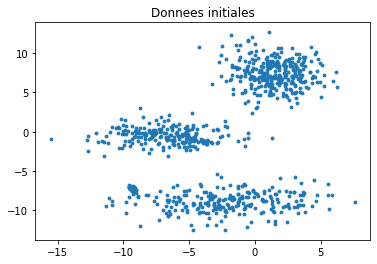

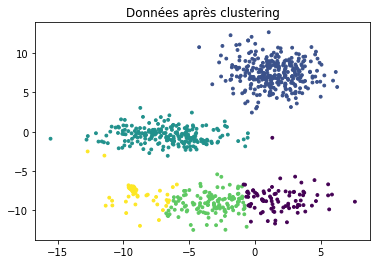

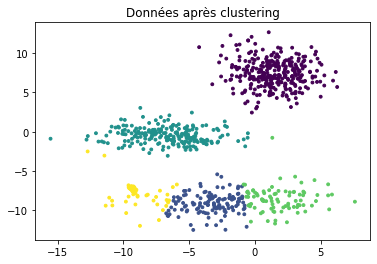

nb clusters = 5 , nb iter = 5 , runtime =  24.06 ms
Coefficient de silhouette :  0.6217134473535465
Indice de Davies Bouldin :  0.554256719880866


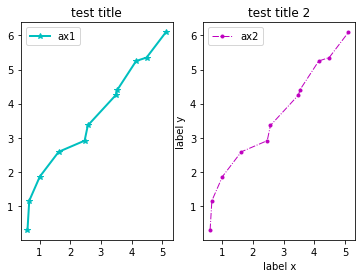

In [4]:
# Parser un fichier de données au format arff
# Data est un tableau d'exemple avec pour chacun les valeurs des features
# Ex : [[-0.499261, -0.0612356], 
#       [-1.51369, 0.265446], 
#       [-1.60321, 0.362039], .....
#      ]
# Note : le jeu de données contient un num du cluster pour chaque point
# --> IGNORER CETTE INFORMATION ....
path = './artificial/'
databrut = arff.loadarff(open(path+"2d-4c-no9.arff", 'r'))
data = [[x[0],x[1]] for x in databrut[0]]
#print(databrut)
#print(data)

# Affichage en 2D
# Extraire chaque valeur de features pour en faire une liste
# Ex pour f0 = [-0.499261, -1.51369, -1.60321, ...]
# Ex pour f1 = [-0.0612356, 0.265446, 0.362039, ...]
f0 = [f[0] for f in data]
f1 = [f[1] for f in data]

plt.scatter(f0, f1, s=8)
plt.title("Donnees initiales")
plt.show()

# #################################################
# Appel d'une méthode de clustering
cl_pred = cluster.KMeans(n_clusters=5, init='k-means++').fit_predict(data)
#print(cl_pred)

# Affichage en 2D avec une couleur pour chaque cluster
plt.scatter(f0, f1, c=cl_pred,s=8)
plt.title("Données après clustering")
plt.show()

# #################################################
# Variantes pour appel d'une méthode de clustering
k=5
tps1 = time.time()
model = cluster.KMeans(n_clusters=k, init='k-means++')
model.fit(data)
tps2 = time.time()
labels = model.labels_
# Nb iteration méthode
iteration = model.n_iter_

plt.scatter(f0, f1, c=labels, s=8)
plt.title("Données après clustering")
plt.show()
print("nb clusters =",k,", nb iter =",iteration, ", runtime = ", round((tps2 - tps1)*1000,2),"ms")
#print("labels", labels)

# Metriques
silh = metrics.silhouette_score(data, model.labels_, metric='euclidean')
dbsc = metrics.davies_bouldin_score(data, model.labels_)
print("Coefficient de silhouette : ", silh)
print("Indice de Davies Bouldin : ", dbsc)

#to arrange the images
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
x = np.random.rand(11).cumsum()
y = np.random.rand(11).cumsum()
ax1.plot(x, y, 'c*-', label='ax1', linewidth=2)
ax2.plot(x, y, 'm.-.', label='ax2', linewidth=1)

ax1.legend()
ax1.set_title('test title')
ax2.legend()
ax2.set_title('test title 2')
ax2.set_xlabel('label x')
ax2.set_ylabel('label y')

plt.show()


#original code for KMEANS
def kMeansCluster(fileTestName,n_clusters):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    starttime = time.time()

    
    data_temp = new_data;
    kmeans = cluster.KMeans(n_clusters, init='k-means++',random_state=3).fit(data_temp)
    labels = kmeans.labels_
    score = metrics.silhouette_score(data_temp, labels, metric='euclidean')
    
    endtime = time.time()
    
    plt.scatter(x_list, y_list, c=labels,s=10,cmap="rainbow")
    plt.show()
    print("Best cluster number : ",n_clusters, " Best score : ",score)
    print("Runtime : ", round((endtime - starttime)*1000,2),"ms")
    
def kMeans(fileTestName, metric):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    [_, cmp] = metric(None, None)
    score_max = cmp*sys.maxsize
    best_kmeans = None
    starttime = time.time()

    for i in range(2,50) :
        data_temp = new_data;
        kmeans = cluster.KMeans(n_clusters=i, init='k-means++',random_state=3).fit(data_temp)
        kmeans_labels = kmeans.labels_
        [score, cmp] = metric(data_temp, kmeans_labels)

        if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
            score_max = score
            best_kmeans=kmeans_labels
    endtime = time.time()

        

    plt.scatter(x_list, y_list, c=best_kmeans,s=10,cmap="rainbow")
    plt.show()
    
    print("Best cluster number : ",best_kmeans.max()+1, " Best score : ",score_max)
    print("Runtime : ", round((endtime - starttime)*1000,2),"ms")
    
    
# #########################################################


def AgglomeratifCluster(fileTestName,manieres,n_clusters):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
        
    starttime = time.time()

    data_temp = new_data;
    kmeans = cluster.AgglomerativeClustering(n_clusters,linkage=manieres, affinity='euclidean').fit(data_temp)
    labels = kmeans.labels_
    score = metrics.silhouette_score(data_temp, labels, metric='euclidean')
    endtime = time.time()
    
    plt.scatter(x_list, y_list, c=labels,s=8,cmap="rainbow")
    plt.show()
    print("best cluster number : ",n_clusters, " best score : ",score)
    print("time execution : ", round((endtime - starttime)*1000,2),"ms")
    
def Agglomeratif(fileTestName,manieres,metric):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    [_, cmp] = metric(None, None)
    score_max = cmp*sys.maxsize
    best_kmeans = None
    starttime = time.time()

    for i in range(2,50) :
        data_temp = new_data;
        kmeans = cluster.AgglomerativeClustering(n_clusters=i,linkage=manieres, affinity='euclidean').fit(data_temp)
        kmeans_labels = kmeans.labels_
        [score, cmp] = metric(data_temp, kmeans_labels)
        
        if (score > score_max and cmp == 0) or (score < score_max and cmp == 1):
            score_max = score
            best_kmeans=kmeans_labels
    endtime = time.time()
    kmeans = cluster.AgglomerativeClustering(n_clusters=i_max,linkage=manieres, affinity='euclidean').fit(data_temp)
    labels = kmeans.labels_
    
    plt.scatter(x_list, y_list, c=best_kmeans,s=8,cmap="rainbow")
    plt.show()
    print("Best cluster number : ",best_kmeans.max()+1, " Best score : ",score_max)
    print("time execution : ", round((endtime - starttime)*1000,2),"ms")

    
# ############################################

def clusterDBSCAN(fileTestName,eps,min_samples):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    
    for (x,y,z) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    starttime = time.time()

    data_temp = new_data;
    kmeans = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(data_temp)
    kmeans_predict = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit_predict(data_temp)
    labels = kmeans.labels_
    
    score = metrics.calinski_harabasz_score(data_temp, labels)
    endtime = time.time()
    
    plt.scatter(x_list, y_list, c=labels,s=8,cmap="rainbow")
    plt.show()
    print(" best score : ",score)
    print("time execution : ", round((endtime - starttime)*1000,2),"ms")
    
# #######################
def clusterHDBSCAN(fileTestName,min_cluster_size):
    data = load_file("./artificial/"+fileTestName)[0]
    new_data = []
    x_list = []
    y_list = []
    for (x,y,_) in data : 
        new_data.append([x,y])
        x_list.append(x)
        y_list.append(y)
    i_max = 0
    score_max = 0
    starttime = time.time()

    data_temp = new_data;
    for i in range(2,min_cluster_size):
        clusterer =  hdbscan.HDBSCAN(i)
        labels =  clusterer.fit(data_temp)
       # score = metrics.silhouette_score(data_temp, labels, metric='euclidean')
        endtime = time.time()
        plt.scatter(x_list, y_list, c=labels,s=8,cmap="rainbow")
        plt.show()
    #print("best cluster number : ",i_max, " best score : ",score_max)
    
        print("number cluster",clusterer.labels_.max()+1,"time execution : ", round((endtime - starttime)*1000,2),"ms")
